In [4]:
import math
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as du

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


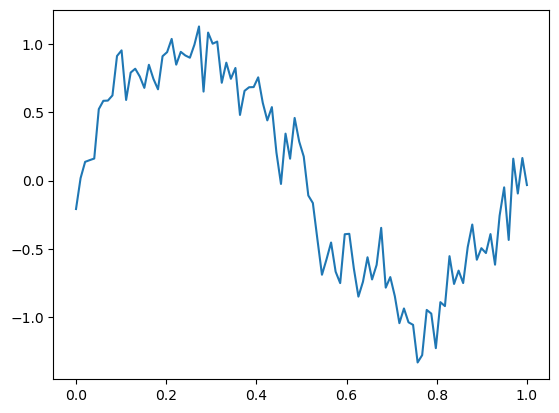

In [7]:
n = 100
train_x = torch.linspace(0, 1, n)
train_y = torch.sin(train_x * (2 * math.pi)) + math.sqrt(0.04) * torch.randn(n)

plt.plot(train_x.detach().numpy(), train_y.detach().numpy())

## GP regression with GPytorch 

 - **GP model** : `gpytorch.models.ExactGP`, handles most of the inference
 - **Likelihood**: `gpytorch.likelihood.GaussianLikelihood`
 - **Mean** (prior): `gpytorch.means.ConstantMean`
 - **Covariance** (prior): `gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())`
 - **Multivariate Normal**: `gpytorch.distributions.MultivariateNormal`

In [18]:
# Define the GP model

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # define the mean and covaraince functions 
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [16]:
# define the liklihood

likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [20]:
# create the model

model = ExactGPModel(train_x, train_y, likelihood)

In [24]:
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [25]:
model.train()

ExactGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [28]:
for name, param in model.named_parameters():
    print(name, param.data)

likelihood.noise_covar.raw_noise tensor([0.])
mean_module.raw_constant tensor(0.)
covar_module.raw_outputscale tensor(0.)
covar_module.base_kernel.raw_lengthscale tensor([[0.]])


In [35]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

train_iter = 50

for i in range(train_iter):
    optimizer.zero_grad()

    # predict y
    output = model(train_x)

    # compute the loss
    loss = -mll(output, train_y)
    loss.backward()

    print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iter, loss.item()))

    optimizer.step()

Iter 1/50 - Loss: 0.927
Iter 2/50 - Loss: 0.895
Iter 3/50 - Loss: 0.861
Iter 4/50 - Loss: 0.823
Iter 5/50 - Loss: 0.781
Iter 6/50 - Loss: 0.733
Iter 7/50 - Loss: 0.682
Iter 8/50 - Loss: 0.631
Iter 9/50 - Loss: 0.581
Iter 10/50 - Loss: 0.535
Iter 11/50 - Loss: 0.494
Iter 12/50 - Loss: 0.456
Iter 13/50 - Loss: 0.419
Iter 14/50 - Loss: 0.384
Iter 15/50 - Loss: 0.349
Iter 16/50 - Loss: 0.314
Iter 17/50 - Loss: 0.279
Iter 18/50 - Loss: 0.245
Iter 19/50 - Loss: 0.210
Iter 20/50 - Loss: 0.176
Iter 21/50 - Loss: 0.142
Iter 22/50 - Loss: 0.108
Iter 23/50 - Loss: 0.076
Iter 24/50 - Loss: 0.045
Iter 25/50 - Loss: 0.015
Iter 26/50 - Loss: -0.013
Iter 27/50 - Loss: -0.039
Iter 28/50 - Loss: -0.063
Iter 29/50 - Loss: -0.083
Iter 30/50 - Loss: -0.101
Iter 31/50 - Loss: -0.116
Iter 32/50 - Loss: -0.127
Iter 33/50 - Loss: -0.135
Iter 34/50 - Loss: -0.141
Iter 35/50 - Loss: -0.143
Iter 36/50 - Loss: -0.144
Iter 37/50 - Loss: -0.143
Iter 38/50 - Loss: -0.141
Iter 39/50 - Loss: -0.139
Iter 40/50 - Loss: -

In [46]:
f_preds = model(train_x)
likelihood(f_preds)

MultivariateNormal(loc: torch.Size([100]))

In [48]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [49]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    pred_dist = model(test_x)
    observed_pred = likelihood(pred_dist)

In [52]:
    observed_pred.confidence_region()

(tensor([-0.3132, -0.1693, -0.0367,  0.0850,  0.1959,  0.2957,  0.3838,  0.4598,
          0.5228,  0.5723,  0.6080,  0.6295,  0.6369,  0.6302,  0.6098,  0.5762,
          0.5297,  0.4712,  0.4013,  0.3208,  0.2306,  0.1320,  0.0261, -0.0858,
         -0.2022, -0.3213, -0.4415, -0.5608, -0.6775, -0.7894, -0.8946, -0.9912,
         -1.0772, -1.1510, -1.2111, -1.2561, -1.2852, -1.2975, -1.2929, -1.2715,
         -1.2336, -1.1799, -1.1117, -1.0303, -0.9374, -0.8352, -0.7263, -0.6136,
         -0.5007, -0.3918, -0.2911]),
 tensor([ 0.4084,  0.5259,  0.6440,  0.7589,  0.8672,  0.9664,  1.0545,  1.1303,
          1.1930,  1.2419,  1.2769,  1.2979,  1.3049,  1.2980,  1.2775,  1.2439,
          1.1974,  1.1389,  1.0689,  0.9883,  0.8981,  0.7993,  0.6933,  0.5814,
          0.4651,  0.3459,  0.2258,  0.1064, -0.0102, -0.1220, -0.2272, -0.3236,
         -0.4096, -0.4834, -0.5434, -0.5884, -0.6175, -0.6297, -0.6250, -0.6031,
         -0.5646, -0.5104, -0.4415, -0.3597, -0.2667, -0.1645, -0.0550,

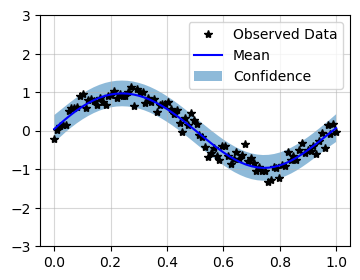

In [55]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    lower, upper = observed_pred.confidence_region()

    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.grid(True, alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Stochastic Variational GP

In [59]:
import torch.utils.data as du

In [121]:
X = torch.randn(1000, 3)
y = X[:, 0] + torch.sin(X[:, 1]) + X[:, 2]**2 + torch.randn(1000) * math.sqrt(0.04)

train_n = int(math.floor(0.8 * len(X)))
train_x = X[:train_n, :].contiguous()
train_y = y[:train_n].contiguous()

test_x = X[train_n:, :].contiguous()
test_y = y[train_n:].contiguous()

In [122]:
train_dataset = du.TensorDataset(train_x, train_y)
train_loader = du.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = du.TensorDataset(test_x, test_y)
test_loader = du.DataLoader(test_dataset, batch_size=128, shuffle=False)

## Variational / Approximate GPs

Need to construct three objects:

- **GP Model**: `gpytorch.models.ApproximateGP`
- **Variational Distribution**: `gpytorch.variational._VariationalDistribution`
- **Variational Strategy**: `gpytorch.variational_VariationalStrategy`

In [139]:
class ApproxGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        # define the variational distribution
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        
        # define the variational strategy
        variational_strat = gpytorch.variational.VariationalStrategy(self, inducing_points, \
            variational_distribution, learn_inducing_locations=True)
        
        super(ApproxGPModel, self).__init__(variational_strat)

        # define the mean and covariance functions
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [123]:
# define the model and likelihood
inducing_points = torch.randn(100, 3)
model = ApproxGPModel(inducing_points)

likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [124]:
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [125]:
optimizer = torch.optim.Adam([{'params': model.parameters()},
                              {'params': likelihood.parameters()}], lr=0.01)

# define the loss
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

train_iter = 1000
for i in range(train_iter):
    # for x_batch, y_batch in train_loader:
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    optimizer.step()

    print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iter, loss.item()))

Iter 1/1000 - Loss: 4.237
Iter 2/1000 - Loss: 4.143
Iter 3/1000 - Loss: 4.054
Iter 4/1000 - Loss: 3.969
Iter 5/1000 - Loss: 3.887
Iter 6/1000 - Loss: 3.809
Iter 7/1000 - Loss: 3.734
Iter 8/1000 - Loss: 3.661
Iter 9/1000 - Loss: 3.591
Iter 10/1000 - Loss: 3.523
Iter 11/1000 - Loss: 3.457
Iter 12/1000 - Loss: 3.394
Iter 13/1000 - Loss: 3.331
Iter 14/1000 - Loss: 3.271
Iter 15/1000 - Loss: 3.213
Iter 16/1000 - Loss: 3.155
Iter 17/1000 - Loss: 3.099
Iter 18/1000 - Loss: 3.045
Iter 19/1000 - Loss: 2.992
Iter 20/1000 - Loss: 2.940
Iter 21/1000 - Loss: 2.889
Iter 22/1000 - Loss: 2.840
Iter 23/1000 - Loss: 2.792
Iter 24/1000 - Loss: 2.745
Iter 25/1000 - Loss: 2.698
Iter 26/1000 - Loss: 2.653
Iter 27/1000 - Loss: 2.610
Iter 28/1000 - Loss: 2.567
Iter 29/1000 - Loss: 2.525
Iter 30/1000 - Loss: 2.485
Iter 31/1000 - Loss: 2.445
Iter 32/1000 - Loss: 2.406
Iter 33/1000 - Loss: 2.368
Iter 34/1000 - Loss: 2.331
Iter 35/1000 - Loss: 2.295
Iter 36/1000 - Loss: 2.260
Iter 37/1000 - Loss: 2.226
Iter 38/10

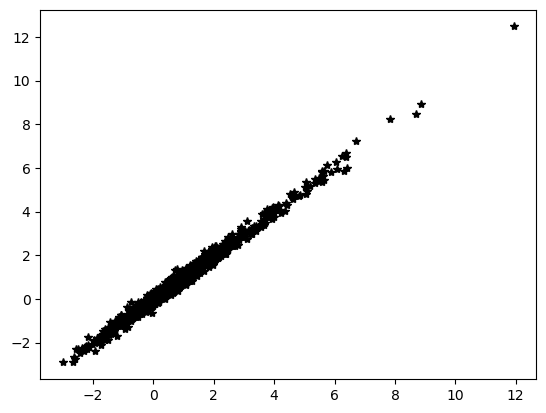

In [126]:
model.eval()
likelihood.eval()


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_pred = model(train_x)

with torch.no_grad():
    plt.plot(f_pred.mean.numpy(), train_y.numpy(), 'k*')

## Classification Example

See: https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html

and

See: https://docs.gpytorch.ai/en/stable/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html

In [113]:
# generate some data
n = 200

train_x = torch.randn(n, 2)
train_y = train_x[:, 0] > train_x[:, 1] 
train_y = train_y.float()

train_data = du.TensorDataset(train_x, train_y)
train_loader = du.DataLoader(train_data, batch_size=128, shuffle=True)

In [114]:
# define the model

class GPClassification(gpytorch.models.ApproximateGP):
    def __init__(self, train_x):
        # define the variational distribution
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(train_x.size(0))

        # define how the variational distribution is computed
        variational_strategy = gpytorch.variational.UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )

        super(GPClassification, self).__init__(variational_strategy)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [115]:
# define the likelihood
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

# define the model
model = ApproxGPModel(train_x)

In [116]:
likelihood.train()
model.train()

ApproxGPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [117]:
# print the model parameters
for name, param in model.named_parameters():
    print(name, param.data)

variational_strategy.inducing_points tensor([[ 1.0900,  1.8656],
        [ 1.0034,  0.6692],
        [ 2.3513,  0.5152],
        [-0.1293,  1.0537],
        [-0.9368, -0.1767],
        [-1.1783, -0.9721],
        [ 1.3617, -0.6907],
        [ 0.1480, -0.3797],
        [-0.4702,  0.7049],
        [ 1.2365, -0.1219],
        [-0.3931,  0.2050],
        [-0.4030,  0.7496],
        [-1.7674, -2.1881],
        [-0.5798, -0.6136],
        [-1.1288, -0.6039],
        [ 0.5973, -0.6319],
        [-2.8155,  0.3630],
        [-0.4251,  1.1325],
        [ 0.8016,  1.8443],
        [ 0.4453,  0.1108],
        [ 1.8812,  0.4210],
        [ 0.8317, -0.6317],
        [ 1.6676,  0.4962],
        [-0.5592,  0.1758],
        [ 0.0655, -0.4600],
        [ 1.7785,  2.6719],
        [-1.6939,  0.0168],
        [ 1.2645, -0.8716],
        [ 1.2666, -1.0794],
        [-1.2403,  0.7160],
        [-1.0768, -0.5747],
        [-0.7913, -0.5538],
        [-0.5292, -1.7698],
        [-0.5217, -0.1319],
        [-2

In [118]:
# optimize the model parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

train_iter = 100

for i in range(train_iter):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    optimizer.step()

    print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iter, loss.item()))

Iter 1/100 - Loss: 0.908
Iter 2/100 - Loss: 1.219
Iter 3/100 - Loss: 0.705
Iter 4/100 - Loss: 0.704
Iter 5/100 - Loss: 0.790
Iter 6/100 - Loss: 0.680
Iter 7/100 - Loss: 0.513
Iter 8/100 - Loss: 0.432
Iter 9/100 - Loss: 0.450
Iter 10/100 - Loss: 0.480
Iter 11/100 - Loss: 0.487
Iter 12/100 - Loss: 0.389
Iter 13/100 - Loss: 0.335
Iter 14/100 - Loss: 0.320
Iter 15/100 - Loss: 0.338
Iter 16/100 - Loss: 0.349
Iter 17/100 - Loss: 0.332
Iter 18/100 - Loss: 0.300
Iter 19/100 - Loss: 0.278
Iter 20/100 - Loss: 0.273
Iter 21/100 - Loss: 0.285
Iter 22/100 - Loss: 0.289
Iter 23/100 - Loss: 0.280
Iter 24/100 - Loss: 0.263
Iter 25/100 - Loss: 0.252
Iter 26/100 - Loss: 0.251
Iter 27/100 - Loss: 0.254
Iter 28/100 - Loss: 0.254
Iter 29/100 - Loss: 0.246
Iter 30/100 - Loss: 0.236
Iter 31/100 - Loss: 0.229
Iter 32/100 - Loss: 0.229
Iter 33/100 - Loss: 0.229
Iter 34/100 - Loss: 0.226
Iter 35/100 - Loss: 0.220
Iter 36/100 - Loss: 0.214
Iter 37/100 - Loss: 0.211
Iter 38/100 - Loss: 0.211
Iter 39/100 - Loss: 0

In [119]:
model.eval()
likelihood.eval()

BernoulliLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
)

In [120]:
# create meshgrid for plotting
test_d1 = np.linspace(-3.5, 3, 20)
test_d2 = np.linspace(-3, 3, 20)
test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)


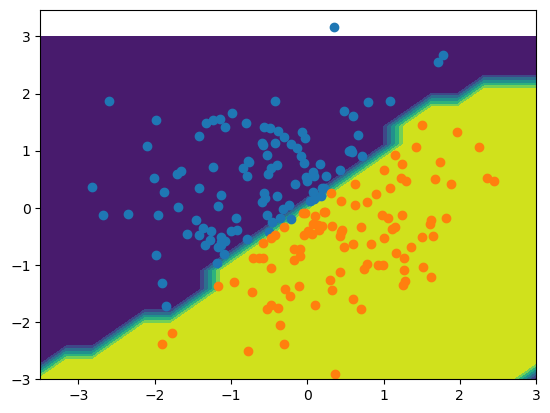

In [121]:
# make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(test_x))

test_labels = predictions.mean.ge(0.5).float().reshape(test_x_mat.shape)

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
# plot with true labels and colours
plt.plot(train_x[train_y==0,0].numpy(), train_x[train_y==0,1].numpy(), 'o')
plt.plot(train_x[train_y==1,0].numpy(), train_x[train_y==1,1].numpy(), 'o')

## GP Logistic Regression with new bound

In [162]:
# generate some data
n = 50000

train_x = torch.randn(n, 2)
train_y = train_x[:, 0] > train_x[:, 1]
train_y = train_y.float()

train_data = du.TensorDataset(train_x, train_y)
train_loader = du.DataLoader(train_data, batch_size=128, shuffle=True)

In [163]:
from torch.special import ndtr, log_ndtr

class LogitLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    has_analytic_marginal = False

    def __init__(self, l_max=12.0):
        self.l_max = l_max
        return super().__init__()
    
    def forward(self, function_samples, *args, **kwargs):
        output_probs = torch.sigmoid(function_samples)
        return torch.distributions.Bernoulli(probs=output_probs)
    
    def expected_log_prob(self, observations, function_dist, *args, **kwargs):
        y = observations
        M = function_dist.mean.unsqueeze(1)
        S = function_dist.stddev.unsqueeze(1)
        V = S**2
        l = torch.arange(1.0, self.l_max*2, 1.0, requires_grad=False).unsqueeze(0)

        res =  \
            torch.dot(- y, M.squeeze()) + \
            torch.sum(
                S / math.sqrt(2 * torch.pi) * torch.exp(- 0.5 * M**2 / V**2) + \
                M * ndtr(M / S)
            ) + \
            torch.sum(
                (-1.0)**(l - 1.0) / l * (
                    torch.exp( M @ l + 0.5 * V @ (l ** 2) + log_ndtr(-M / S - S @ l)) + \
                    torch.exp(-M @ l + 0.5 * V @ (l ** 2) + log_ndtr( M / S - S @ l))
                )
            )

        return - res

In [164]:
# model = ApproxGPModel(train_x)
# model = GPClassification(train_x)
inducing_points = torch.randn(50, 2)
model = ApproxGPModel(inducing_points)
likelihood = LogitLikelihood()

In [165]:
model.train()
likelihood.train()

LogitLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
)

In [166]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.3)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

In [167]:
%timeit -n 1 -r 1 optimizer.step()

train_iter = 100

for i in range(train_iter):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    optimizer.step()

    if i % 20 == 0: 
        print('Iter %d/%d - Loss: %.3f' % (i + 1, train_iter, loss.item()))

268 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Iter 1/100 - Loss: 0.774
Iter 21/100 - Loss: 0.075
Iter 41/100 - Loss: 0.036
Iter 61/100 - Loss: 0.033
Iter 81/100 - Loss: 0.025


In [170]:
# create meshgrid for plotting
test_d1 = np.linspace(-5, 5, 20)
test_d2 = np.linspace(-5, 5, 20)
test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)

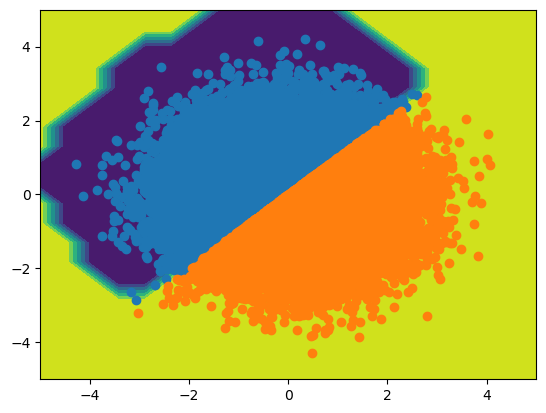

In [172]:
# make predictions

with torch.no_grad(), gpytorch.settings.num_likelihood_samples(1000):
    predictions = likelihood(model(test_x))

test_labels = predictions.mean.mean(dim=0).ge(0.5).float().reshape(test_x_mat.shape)

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
plt.plot(train_x[train_y==0,0].numpy(), train_x[train_y==0,1].numpy(), 'o')
plt.plot(train_x[train_y==1,0].numpy(), train_x[train_y==1,1].numpy(), 'o')